In [3]:
from src.models.motion_environment_factory import PlumeMotionNavigationEnvironmentMovie1PlumeSourceRewardFactory
from src.models.goals import GOAL_X,GOAL_Y,GOAL_RADIUS
import os
movie_path = os.path.join('..','src','data','plume_movies','intermittent_smoke.avi')
environment = PlumeMotionNavigationEnvironmentMovie1PlumeSourceRewardFactory(movie_file_path=movie_path).plume_environment
environment.reset()
print(environment.odor_plume.frame.shape)

Got no randomization bounds
(1532, 898)


post position:  [1215.94655506  432.9192719 ]
concentration 254 1
gradient -2.36043956043956 2
motion 0.0 0


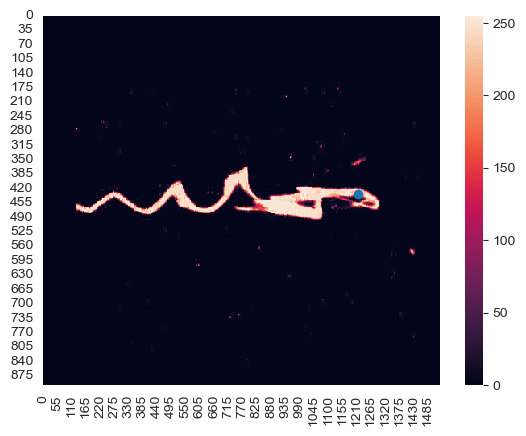

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
#ax = plt.figure().gca()


for t_step in range(1000):
    action = environment.action_space.sample()
    pre_position = environment.fly_spatial_parameters.position
    observation, _, _, _ = environment.step(action)
    if environment.odor_features.concentration > 100:
        sns.heatmap(environment.odor_plume.frame.T)
        plt.scatter(environment.fly_spatial_parameters.position[0],environment.fly_spatial_parameters.position[1])
        print('post position: ', environment.fly_spatial_parameters.position)
        print('concentration', environment.odor_features.concentration, observation[0])
        print('gradient', environment.odor_features.gradient, observation[1])
        print('motion', environment.odor_features.motion_speed, observation[2])
        break


In [4]:
import numpy as np
from src.models.action_definitions import WalkActionEnum
from gym.spaces import MultiDiscrete, Discrete

q_shape = np.append(environment.observation_space.nvec,environment.action_space.n)
q_table = np.zeros(shape=q_shape)

## Odor seeking
The training method below tends to lead agents to "ride" oncoming odor tendrils

In [2]:
import numpy as np

q_shape = np.append(environment.observation_space.nvec,environment.action_space.n)
q_table = np.zeros(shape=q_shape)
N_EPISODES = 100
ALPHA = 0.2
GAMMA = 0.5
MAX_EPSILON = 1
MIN_EPSILON = 0.1
DECAY = 0.1

MIN_RESET_X = GOAL_X+GOAL_RADIUS + 10
MAX_RESET_X = 140
MIN_RESET_Y_SPREAD = 2*GOAL_RADIUS
MAX_RESET_Y_SPREAD = 3*GOAL_RADIUS
rewards = np.zeros(N_EPISODES)
odor_on_values = np.zeros(N_EPISODES)
odor_off_values = np.zeros(N_EPISODES)

NameError: name 'environment' is not defined

In [21]:
import tqdm.notebook
epsilon = MAX_EPSILON
alpha = ALPHA
rng = np.random.default_rng(seed=1234)
for episode in tqdm.notebook.tqdm(range(N_EPISODES)):
    n_chosen_actions = 0
    odor_on_values[episode] = np.mean(q_table[(1,slice(None),slice(None),slice(None))].flatten())
    odor_off_values[episode] = np.mean(q_table[(0,slice(None),slice(None),slice(None))].flatten())
    if episode < 50:
        print(f'Overall value in "on", episode {episode}:', odor_on_values[episode],'... "off:', odor_off_values[episode])
    elif episode % 10 == 0:
        print(f'Overall value in "on", episode {episode}:', odor_on_values[episode],'... "off:', odor_off_values[episode])
        print(f'epsilon: {epsilon}')
    observation = environment.reset()
    done = False
    while not done:
        explore = rng.random() < epsilon# Can pick all random numbers at start
        if explore:
            action = environment.action_space.sample()
            log_reward = False
        else:
            action = np.argmax(q_table[tuple(observation)])
            log_reward = True
            n_chosen_actions += 1
        new_observation, reward, done, odor_measures = environment.step(action)
        if log_reward: rewards[episode] += reward # track the accumulation of reward only when the action was not selected at random
        update_index = tuple(np.append(observation,action))
        t1_value_index = tuple(new_observation)# Note the use of this index requires actions to be last axes of q table
        q_table[update_index] = \
            q_table[update_index] +\
            ALPHA * (reward + GAMMA*np.max(q_table[t1_value_index]) -\
            q_table[update_index])
        observation = new_observation
    epsilon = MIN_EPSILON + (MAX_EPSILON-MIN_EPSILON)*np.exp(-DECAY*episode)
    if n_chosen_actions > 0:
        rewards[episode] = rewards[episode]/n_chosen_actions

    if episode > 50:
        print("---------------------------")
        alpha = 0.15
        print(f'epsilon: {epsilon}', f'alpha: {alpha}')
    if episode > 75:
        print("---------------------------")
        alpha = 0.1
        print(f'epsilon: {epsilon}', f'alpha: {alpha}')
    if episode > 90:
        print("---------------------------")
        alpha = 0.05
        print(f'epsilon: {epsilon}', f'alpha: {alpha}')

  0%|          | 0/100 [00:00<?, ?it/s]

Overall value in "on", episode 0: 0.0 ... "off: 0.0
Overall value in "on", episode 1: 0.3307974799272441 ... "off: 0.0896940409352996
Overall value in "on", episode 2: 0.4323210933390747 ... "off: 0.12198855685051137
Overall value in "on", episode 3: 0.7219756344906064 ... "off: 0.1822114423125581
Overall value in "on", episode 4: 0.812512415196228 ... "off: 0.19944470521697855
Overall value in "on", episode 5: 0.9004667533473908 ... "off: 0.1908159137789223
Overall value in "on", episode 6: 0.9101361304365878 ... "off: 0.21781087960554846
Overall value in "on", episode 7: 0.9167471555661031 ... "off: 0.2579374575677792
Overall value in "on", episode 8: 0.8639205223930002 ... "off: 0.24011737097213104
Overall value in "on", episode 9: 0.9073587548603749 ... "off: 0.22281017952353988
Overall value in "on", episode 10: 0.918294124924397 ... "off: 0.23496006943056783
Overall value in "on", episode 11: 0.8795762221748628 ... "off: 0.18231977969660582
Overall value in "on", episode 12: 0.90

In [15]:
np.save('../trained_models/updated_q.npy',q_table)

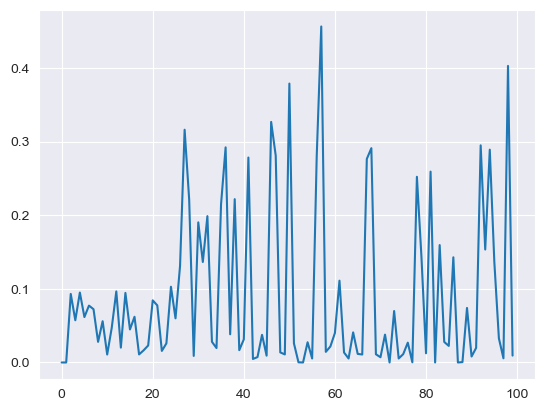

In [22]:
import matplotlib.pyplot as plt
plt.plot(rewards)

In [16]:
import src.visualization.visualize_behavior
src.visualization.visualize_behavior.main(movie_path='../src/data/plume_movies/intermittent_smoke.avi',q_table_path='../trained_models/updated_q.npy',savepath='../result_images/q_walking_frames')

## Below trying to reward source finding

In [2]:
import os
import numpy as np
from src.models.motion_environment_factory import PlumeMotionNavigationEnvironmentMovie1PlumeSourceRewardFactory
from src.models.goals import GOAL_X,GOAL_Y,GOAL_RADIUS

movie_path = os.path.join('..','src','data','plume_movies','intermittent_smoke.avi')
environment = PlumeMotionNavigationEnvironmentMovie1PlumeSourceRewardFactory(movie_file_path=movie_path).plume_environment

q_shape = np.append(environment.observation_space.nvec,environment.action_space.n)
q_table = np.zeros(shape=q_shape)
N_EPISODES = 2000
ALPHA = 0.1
GAMMA = 0.5
MAX_EPSILON = 1
MIN_EPSILON = 0.1
DECAY = 0.1

MIN_RESET_X = GOAL_X + 10 + GOAL_RADIUS
MAX_RESET_X = 1430
rewards = np.zeros(N_EPISODES)
total_rewards = 0

In [3]:
import tqdm.notebook
epsilon = MAX_EPSILON
alpha = ALPHA
rng = np.random.default_rng(seed=1234)
min_reset_x = MIN_RESET_X
max_reset_x = min_reset_x + GOAL_RADIUS
print(f'starting less than {max_reset_x} away in x coordinate')
reset_y_radius = 400
#print(f'starting less than {reset_y_radius} away in y coordinate')
transition_incrementer = 0
parameter_decay = 0
for episode in tqdm.notebook.tqdm(range(N_EPISODES)):
    if (transition_incrementer > 0) & (transition_incrementer % 10 == 0):
        transition_incrementer -= 10
        old_reset_x = max_reset_x
        old_reset_y = reset_y_radius
        max_reset_x = np.min([MAX_RESET_X,GOAL_RADIUS+max_reset_x])
        #reset_y_radius = np.min([MAX_RESET_Y_RADIUS, reset_y_radius + GOAL_RADIUS])

        if (old_reset_x != min_reset_x):

            print('Making task harder')
            print(f'starting less than {max_reset_x} away in x coordinate')
            parameter_decay -= 3 # Increase exploration rate a bit following the change in initialization conditions

    flip = np.random.choice([True,False],1)
    observation = environment.reset(options={'randomization_x_bounds':np.array([min_reset_x,min_reset_x+GOAL_RADIUS]),
                                             'randomization_y_bounds': np.array([-reset_y_radius, reset_y_radius]) + GOAL_Y,
                                             'flip':flip})

    done = False
    while not done:
        explore = rng.random() < epsilon# Can pick all random numbers at start
        if explore:
            action = environment.action_space.sample()
        else:
            action = np.argmax(q_table[tuple(observation)])

        new_observation, reward, done, odor_measures = environment.step(action)
        if reward > 0:
            transition_incrementer += 1
            parameter_decay +=1
            total_rewards += 1
            print('received reward')
        update_index = tuple(np.append(observation,action))
        t1_value_index = tuple(new_observation)# Note the use of this index requires actions to be last axes of q table
        q_table[update_index] = \
            q_table[update_index] +\
            ALPHA * (reward + GAMMA*np.max(q_table[t1_value_index]) -\
            q_table[update_index])
        observation = new_observation


        epsilon = MIN_EPSILON + (MAX_EPSILON-MIN_EPSILON)*np.exp(-DECAY*parameter_decay)
np.save('../trained_models/q_toSource_22_12_14.npy',q_table)

starting less than 230 away in x coordinate


/Users/samuelbrudner/.conda/envs/plume_rl/lib/python3.10/site-packages/traitlets/traitlets.py:1009: DeprecationWarning: Widget._active_widgets is deprecated.
  value = getattr(cls, name)
/Users/samuelbrudner/.conda/envs/plume_rl/lib/python3.10/site-packages/traitlets/traitlets.py:1009: DeprecationWarning: Widget._widget_types is deprecated.
  value = getattr(cls, name)
/Users/samuelbrudner/.conda/envs/plume_rl/lib/python3.10/site-packages/traitlets/traitlets.py:1009: DeprecationWarning: Widget.widget_types is deprecated.
  value = getattr(cls, name)
/Users/samuelbrudner/.conda/envs/plume_rl/lib/python3.10/site-packages/traitlets/traitlets.py:1009: DeprecationWarning: Widget.widgets is deprecated.
  value = getattr(cls, name)


  0%|          | 0/2000 [00:00<?, ?it/s]

received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
Making task harder
starting less than 265 away in x coordinate
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
Making task harder
starting less than 300 away in x coordinate
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
Making task harder
starting less than 335 away in x coordinate
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
received reward
Making task harder
starting less than 370 away in x coordinate
received reward
received reward
received reward
received reward
received reward
received reward
received rew

In [1]:
import src.visualization.visualize_behavior
import numpy as np
q_table = np.load('../trained_models/q_toSource_22_12_14.npy')

src.visualization.visualize_behavior.main(movie_path='../src/data/plume_movies/intermittent_smoke.avi',q_table_path='../trained_models/q_toSource_22_12_14.npy',savepath='../result_images/q_toSource_new')


KeyboardInterrupt



Error in callback <function flush_figures at 0x145b2fac0> (for post_execute):



KeyboardInterrupt



In [ ]:
import seaborn as sns
print(environment.odor_plume.frame.shape)
